In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from ddpm.pipeline import DDPMPipeline
from ddpm.diffusion import GaussianDiffusion
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms.v2 as v2
import ddpm.utils as utils
from ddpm.unet import UNet

# Training DDPMs on Fashion MNIST
We train an DDPM on the Fashion MNIST dataset for `50` epochs, using the Adam optimizer with a learning rate of `3e-4`. The U-Net has a model channel of `64`, `4` downsampling blocks, and `2` resnet blocks. We apply self-attention at the 2x downsampling block. There are corresponding skip connections at the respective upsampling and downsampling blocks.

We use a linear noise schedule with $\beta_1=0.0001$ and $\beta_T=0.02$ with timesteps $T=100$.

Loading the DDPM pipeline.

In [4]:
pipe = DDPMPipeline.from_checkpoint("../ddpm_fashionmnist").to("cuda")

Load U-Net and initialize `GaussianDiffusion` object

In [5]:
diffusion = pipe.diffusion

In [6]:
unet = pipe.model

Load FashionMNIST Dataset

In [7]:
convert_image_to_tensor = v2.Compose([
    v2.ToTensor(),
    v2.Resize((32, 32))
])

convert_tensor_to_image = v2.ToPILImage(mode="L")

/home/ubuntu/.cache/pypoetry/virtualenvs/ddpm-NolEjOLK-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
dataset = FashionMNIST(root="../data", download=True, train=False)
image = dataset[0][0]

batch = convert_image_to_tensor(image).unsqueeze(0).to("cuda")
batch.shape

/home/ubuntu/.cache/pypoetry/virtualenvs/ddpm-NolEjOLK-py3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 1, 32, 32])

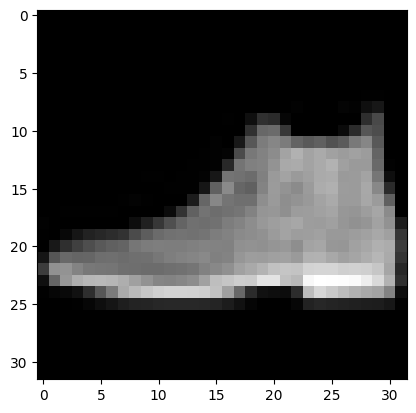

In [9]:
plt.imshow(convert_tensor_to_image(batch.squeeze(0)), cmap="gray")

## Forward Diffusion
We add gaussian noise according to a noise schedule for `T` timesteps. The image looks progressively more like random noise.

In [12]:
num_noise_timesteps = 10

noise_timesteps = torch.linspace(0, diffusion.noise_schedule.timesteps, num_noise_timesteps + 1).to("cuda").int()[1:] - 1
noise = torch.randn((num_noise_timesteps, 1, 32, 32)).to("cuda")

samples = batch.repeat(num_noise_timesteps, 1, 1, 1)
noised_samples = diffusion.q_sample(samples, noise_timesteps, noise)
noised_samples_images = [convert_tensor_to_image(sample) for sample in noised_samples]
noised_samples_grid = utils.make_image_grid([convert_tensor_to_image(batch.squeeze(0)), *noised_samples_images], rows=1, cols=num_noise_timesteps + 1)

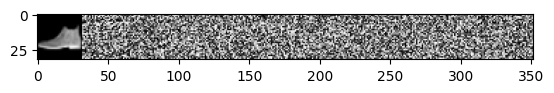

In [13]:
plt.imshow(noised_samples_grid, cmap="gray")

## Reverse Diffusion
We iteratively remove noise for `T` timesteps to get the denoised sample. 

In [14]:
diffusion.to("cuda")
unet.to("cuda")

UNet(
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): Swish()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (in_layer): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsamples): ModuleList(
    (0-1): 2 x TimeSequential(
      (layers): ModuleList(
        (0): ResNetBlock(
          (in_layers): Sequential(
            (0): GroupNorm(32, 64, eps=1e-05, affine=True)
            (1): Swish()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_layers): Sequential(
            (0): Swish()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm(32, 64, eps=1e-05, affine=True)
            (1): Swish()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (s

In [15]:
denoised_samples_output = diffusion.p_sample(unet, noised_samples, noise_timesteps)
denoised_samples_images = [convert_tensor_to_image(sample) for sample in denoised_samples_output.prev_sample]
noised_samples_grid = utils.make_image_grid([convert_tensor_to_image(batch.squeeze(0)), *denoised_samples_images], rows=1, cols=num_noise_timesteps + 1)

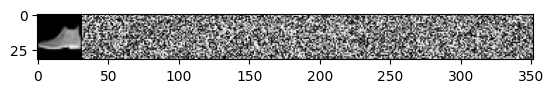

In [16]:
plt.imshow(noised_samples_grid, cmap="gray")

## Unconditioned Generation
We show unconditional Fashion MNIST generations

In [17]:
output = pipe(
    num_images=1,
    image_size=32,
    output_samples=True,
    clip_denoised=False
)

  0%|          | 2/1000 [00:00<00:58, 17.03it/s]

100%|██████████| 1000/1000 [00:24<00:00, 41.10it/s]


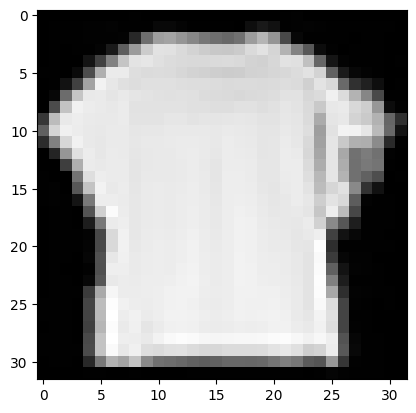

In [18]:
plt.imshow(output.images[0], cmap="gray")

## Predicting `x_0` from Noise
The U-Net receives `x_t` and `t` and predicts the noise added to `x_0` to get to `x_t`. After reparameterization, we find that predicting noise is equivalent to predicting `x_0`. Here, we show the predicted `x_0` for `x_t` at different timesteps.

In [19]:
pred_x0_images = [convert_tensor_to_image(sample) for sample in denoised_samples_output.pred_x0]
noised_samples_grid = utils.make_image_grid([convert_tensor_to_image(batch.squeeze(0)), *pred_x0_images], rows=1, cols=num_noise_timesteps + 1)

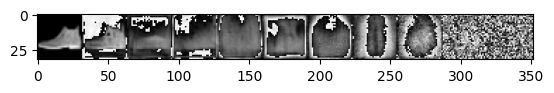

In [20]:
plt.imshow(noised_samples_grid, cmap="gray")